In [ ]:
# agglom by k across k models (4.6.20)


In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
sys.path.append('/Users/lee_jollans/PycharmProjects/mdd_clustering/')
sys.path.append('/Users/lee_jollans/PycharmProjects/mdd_clustering/cv_clustering')
sys.path.append('/Users/lee_jollans/Projects/clustering_pilot/may2020_evaluation/')
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import pathlib
from scipy.cluster.hierarchy import dendrogram
from cv_clustering.mainfoldaggr import plot_dendrogram
from sklearn.manifold import TSNE
from cv_clustering.utils import colorscatter
from cv_clustering.beta_aggregate import vector_mse, get_proba
from sklearn.metrics import explained_variance_score, silhouette_score
import copy
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from numpy import savetxt
import statsmodels.api as sm
from statsmodels.formula.api import ols

sets = ["Tc", "Sc", "TSc", "Tc_tc", "Sc_sc", "TSc_tsc", "Tct_s", "Scs_s", "Tct_Scs_s", "Tct_tc_s", "Scs_sc_s", "Tct_Scs_tc_sc_s"]
setsize=np.array([82,82,150,84,84,154,82,82,150,84,84,154])
n_cv_folds = 4
n_k = 8

input_filedir = '/Users/lee_jollans/Projects/clustering_pilot/FEB_PUT/FEB_'
modstr = '_mod_ctrl_'
input_filedirn = '/Users/lee_jollans/Projects/clustering_pilot/null/MDDnull/MDD__'
modstrn = '_mod_null_'

input_filediri = '/Users/lee_jollans/Projects/clustering_pilot/IXI2/act/IXI2_'
modstri = '_mod_'
input_filedirin = '/Users/lee_jollans/Projects/clustering_pilot/IXI2/null2/IXI2_'
modstrin = '_mod_null_'

In [48]:
def k_clus_comp(tmp):
    allmses = np.full([len(tmp), len(tmp), tmp[0].shape[1], tmp[0].shape[1]], np.nan)
    allvarexp = np.full([len(tmp), len(tmp), tmp[0].shape[1], tmp[0].shape[1]], np.nan)
    allcorrs = np.full([len(tmp), len(tmp), tmp[0].shape[1], tmp[0].shape[1]], np.nan)
    for mf1 in range(len(tmp)):
        for mf2 in range(len(tmp)):
            if mf1 < mf2:
                for c1 in range(tmp[0].shape[1]):
                    for c2 in range(tmp[0].shape[1]):
                        a = tmp[mf1][:, c1]
                        b = tmp[mf2][:, c2]
                        allmses[mf1, mf2, c1, c2] = vector_mse(a, b)
                        allcorrs[mf1, mf2, c1, c2] = np.corrcoef(a, b)[0, 1] ** 2
                        ttt=(explained_variance_score(a, b) + explained_variance_score(b,a)) / 2
                        allvarexp[mf1, mf2, c1, c2] = ttt
                        allvarexp[mf2, mf1, c2, c1] = ttt
    return allmses, allcorrs, allvarexp

In [5]:
# step 1: collect all vectors across subfolds for each k    

s=0
mf=0
k_collect = [None]*n_k
    
for k in range(n_k):

    k_collect[k]=np.empty((setsize[s],0),int)
    for sf in range(n_cv_folds):
        fold=(mf*n_cv_folds)+sf
        filestr=(input_filedir + sets[s] + modstr + str(fold))
        with open(filestr, "rb") as f:
            mod = pickle.load(f)

        if k==0:
            crit=np.nanmean(mod.allbetas[k],axis=1)
            crit=np.array([crit,-crit]).T
            criti=np.nanmean(mod.allitcpt[k])
            criti = np.array([criti, -criti]).T
        else:
            crit=np.nanmean(mod.allbetas[k],axis=2)
            criti=np.nanmean(mod.allitcpt[k],axis=1)

        k_collect[k] = np.append(k_collect[k],crit, axis=1)

    print(k_collect[k].shape)


(82, 8)
(82, 12)
(82, 16)
(82, 20)
(82, 24)
(82, 28)
(82, 32)
(82, 36)


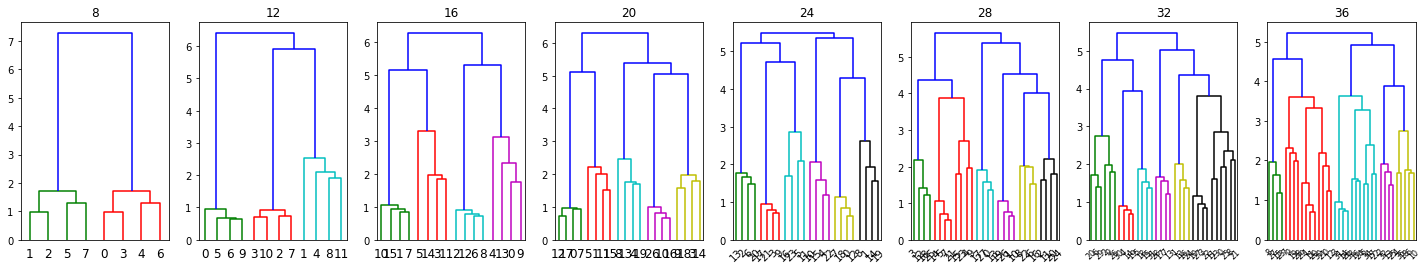

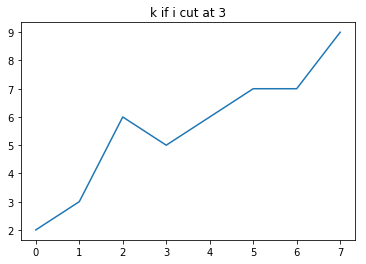

In [20]:
# step 2: create tree for each to visualize
k_trees = []
n_clus_with_cut3=np.zeros(8)
fig=plt.figure(figsize=[25,4])
for k in range(n_k):
    clustering = AgglomerativeClustering(compute_full_tree=True, distance_threshold=3, n_clusters=None,linkage='ward').fit(k_collect[k].T)
    n_clus_with_cut3[k]=len(np.unique(clustering.labels_))
    k_trees.append(clustering)
    plt.subplot(1,8,k+1)
    plot_dendrogram(clustering)
    plt.title(clustering.n_leaves_)
plt.show()
plt.plot(n_clus_with_cut3); plt.title('k if i cut at 3');plt.show()

# color threshold is set to 0.7*max(Z[:,2]) so 70% of the highest distance between nodes

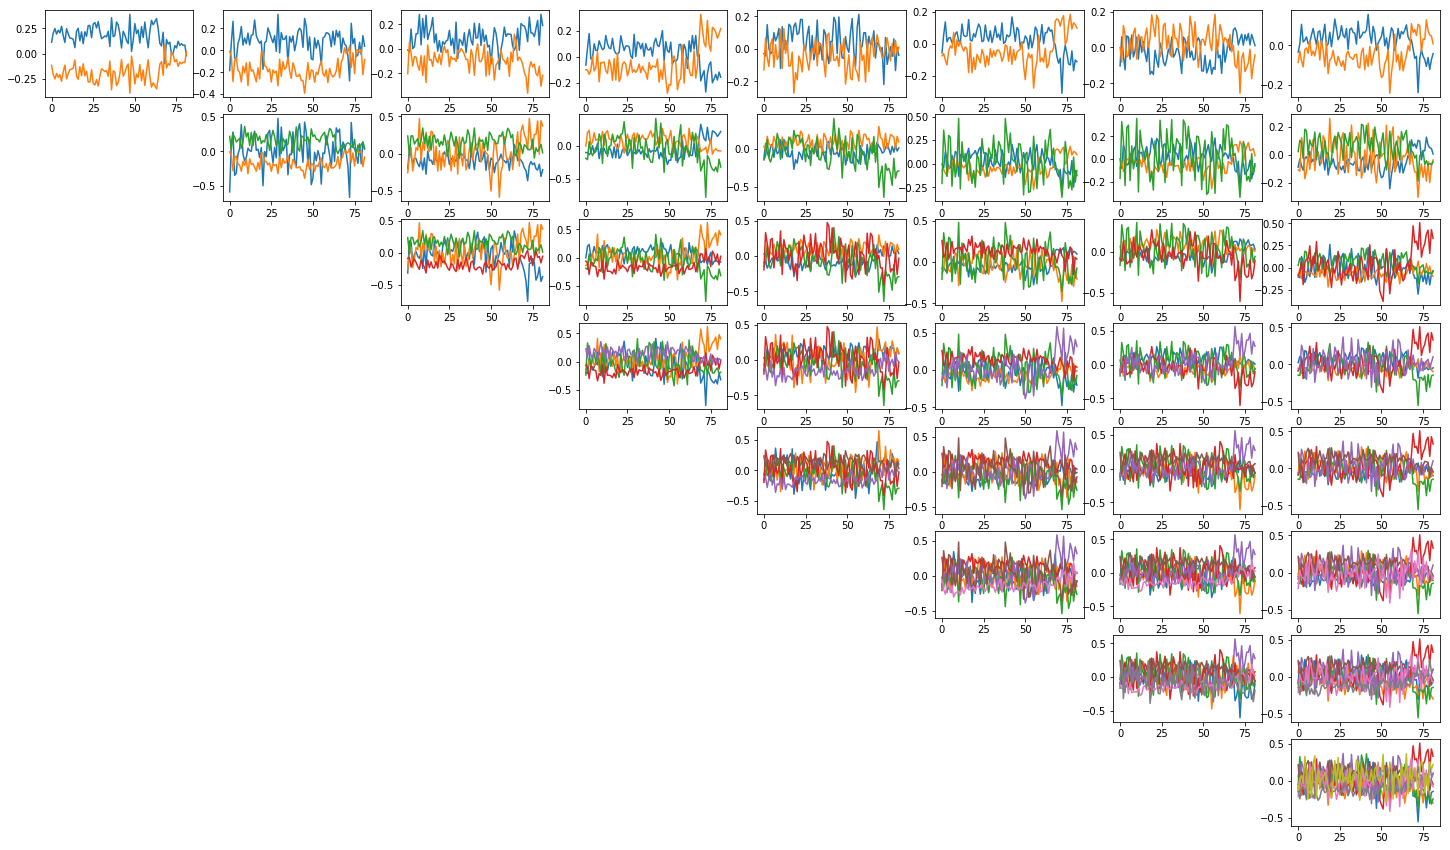

In [51]:
# step 3: force k threshold
fig=plt.figure(figsize=[25,15])
ctr=0
avgclus=[None]*n_k
for kthresh in range(n_k):
    avgclus[kthresh]=[]
    for k in range(n_k):
        ctr+=1
        if k>=kthresh:
            plt.subplot(n_k,n_k,ctr)
            clustering = AgglomerativeClustering(n_clusters=kthresh+2,linkage='ward').fit(k_collect[k].T)
            avgbs=np.full([k_collect[k].shape[0],kthresh+2],np.nan)
            for c in range(kthresh+2):
                avgbs[:,c]=np.nanmean(k_collect[k][:,np.where(clustering.labels_==c)[0]],axis=1)
            plt.plot(avgbs)
            avgclus[kthresh].append(avgbs)

/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


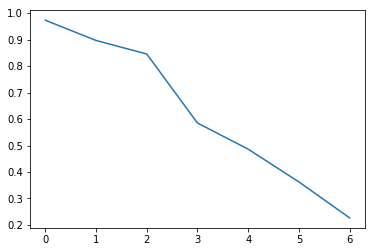

In [54]:
#step 4: calculate match between each solution
averageerror=np.zeros(n_k)
for kthresh in range(n_k):
    bestmatch = []
    for mf1 in range(len(avgclus[kthresh])):
        for mf2 in range(len(avgclus[kthresh])):
            if mf1 != mf2:
                allmses = np.full([kthresh+2,kthresh+2],np.nan)
                for c1 in range(kthresh+2):
                    for c2 in range(kthresh+2):
                        a = avgclus[kthresh][mf1][:, c1]
                        b = avgclus[kthresh][mf2][:, c2]
                        allmses[c1, c2] = vector_mse(a, b)
                for c in range(kthresh+2):
                    a=np.where(allmses==np.nanmin(allmses))
                    bestmatch.append(np.nanmin(allmses))
                    allmses[a[0][0],:]=np.nan
                    allmses[:,a[1][0]]=np.nan
    averageerror[kthresh]=np.nanmean(np.array(bestmatch))
plt.plot(averageerror)

In [63]:
# stick everything into one function and do it for all sets
def doagglomchks(s, link):
    
    # step 1: collect all vectors across subfolds for each k    
    mf=0
    k_collect = [None]*n_k

    for k in range(n_k):

        k_collect[k]=np.empty((setsize[s],0),int)
        for sf in range(n_cv_folds):
            fold=(mf*n_cv_folds)+sf
            filestr=(input_filediri + sets[s] + modstri + str(fold))
            with open(filestr, "rb") as f:
                mod = pickle.load(f)

            if k==0:
                crit=np.nanmean(mod.allbetas[k],axis=1)
                crit=np.array([crit,-crit]).T
                criti=np.nanmean(mod.allitcpt[k])
                criti = np.array([criti, -criti]).T
            else:
                crit=np.nanmean(mod.allbetas[k],axis=2)
                criti=np.nanmean(mod.allitcpt[k],axis=1)

            k_collect[k] = np.append(k_collect[k],crit, axis=1)

    
    # step 3: force k threshold
    avgclus=[None]*n_k
    for kthresh in range(n_k):
        avgclus[kthresh]=[]
        for k in range(n_k):
            if k>=kthresh:
                if link==0:
                    clustering = AgglomerativeClustering(n_clusters=kthresh+2,linkage='ward').fit(k_collect[k].T)
                elif link==1:
                    clustering = AgglomerativeClustering(n_clusters=kthresh+2,linkage='complete').fit(k_collect[k].T)
                elif link==2:
                    clustering = AgglomerativeClustering(n_clusters=kthresh+2,linkage='average').fit(k_collect[k].T)
                else:
                    print('please select linkage function')
                avgbs=np.full([k_collect[k].shape[0],kthresh+2],np.nan)
                for c in range(kthresh+2):
                    avgbs[:,c]=np.nanmean(k_collect[k][:,np.where(clustering.labels_==c)[0]],axis=1)
                avgclus[kthresh].append(avgbs)
                
    #step 4: calculate match between each solution
    averageerror=np.zeros(n_k)
    for kthresh in range(n_k):
        bestmatch = []
        for mf1 in range(len(avgclus[kthresh])):
            for mf2 in range(len(avgclus[kthresh])):
                if mf1 != mf2:
                    allmses = np.full([kthresh+2,kthresh+2],np.nan)
                    for c1 in range(kthresh+2):
                        for c2 in range(kthresh+2):
                            a = avgclus[kthresh][mf1][:, c1]
                            b = avgclus[kthresh][mf2][:, c2]
                            allmses[c1, c2] = vector_mse(a, b)
                    for c in range(kthresh+2):
                        a=np.where(allmses==np.nanmin(allmses))
                        bestmatch.append(np.nanmin(allmses))
                        allmses[a[0][0],:]=np.nan
                        allmses[:,a[1][0]]=np.nan
        averageerror[kthresh]=np.nanmean(np.array(bestmatch))
    return averageerror

/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-

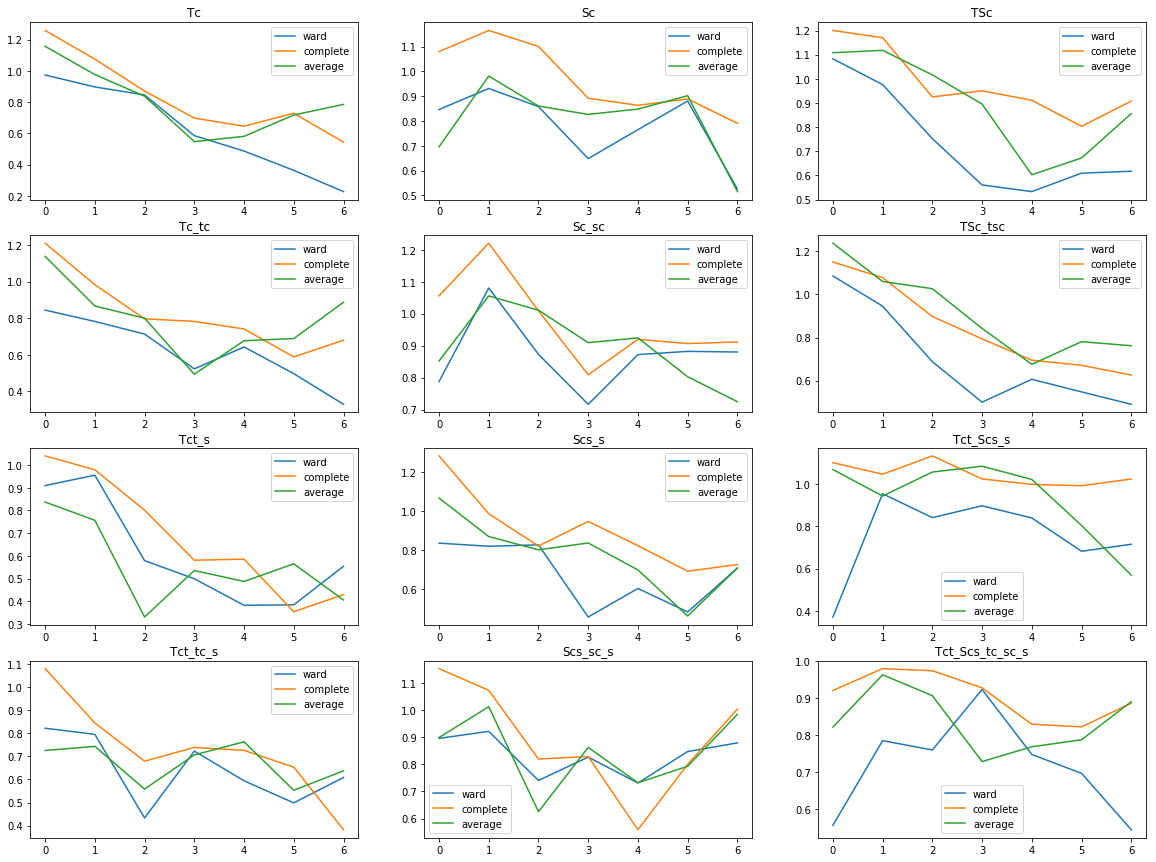

In [60]:
fig=plt.figure(figsize=[20,15])
allerror=np.full([12,3,8],np.nan)
for s in range(12):
    plt.subplot(4,3,s+1)
    for link in range(3):
        averageerror=doagglomchks(s, link)
        allerror[s,link,:]=averageerror
        plt.plot(averageerror)
    plt.legend(['ward','complete','average'])
    plt.title(sets[s])
plt.show()

/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/lee_jollans/anaconda3/lib/python3.7/site-

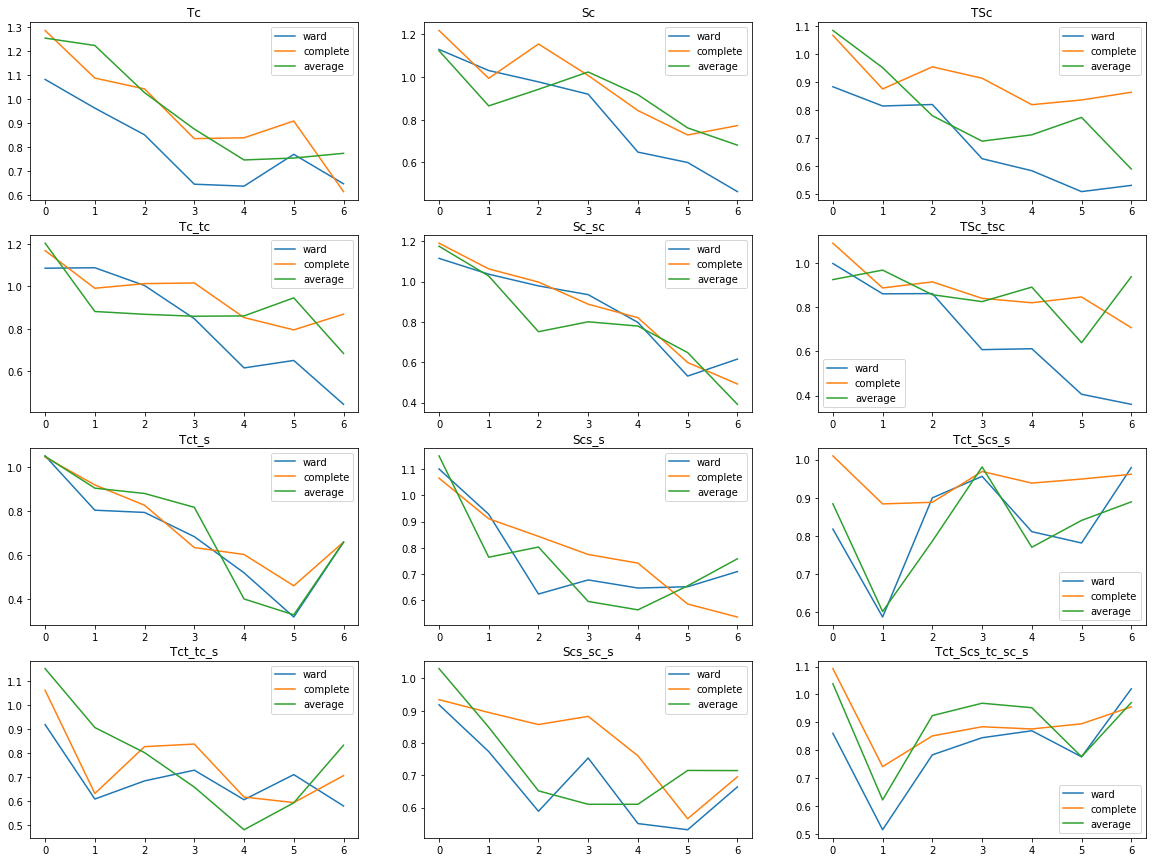

In [64]:
fig=plt.figure(figsize=[20,15])
allerrori=np.full([12,3,8],np.nan)
for s in range(12):
    plt.subplot(4,3,s+1)
    for link in range(3):
        averageerror=doagglomchks(s, link)
        allerrori[s,link,:]=averageerror
        plt.plot(averageerror)
    plt.legend(['ward','complete','average'])
    plt.title(sets[s])
plt.show()